In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
calib_ = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

# calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]

calib_maglim = [44536,68535,5896,48334, 40809]  # reject

# calib_weird = [68535, 28378, 42081, 39461, 44536, 21102,50073, 5896, 15345] # infrared
calib_weird = [68535, 28378, 42081, 39461, 44536]   # optical


for col in calib_.columns:
    newcol = col.strip()
    calib_.rename(columns={col:newcol}, inplace=True)

calib_['I'] = calib_.i-calib_.dm19

calib_ = calib_[(calib_.I>-17)&(calib_.i>0)]
    
calib_.head(20)

,PGC,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,...,NW1,MW2,u,g,r,i,z,W1,W2,I
23,3974,1,UGC685,28.41,64,1.880,0.029,-13.98,-14.99,-15.33,...,0.00,0.00,14.43,13.42,13.08,12.90,12.79,0.00,0.00,-15.51
27,6699,1,UGC1281,28.61,90,2.034,0.008,-15.67,-16.28,-16.46,...,-15.39,-14.85,12.94,12.33,12.15,11.74,11.79,13.22,13.76,-16.87
37,19871,1,UGC3600,30.04,81,1.999,0.036,-14.82,-15.37,-15.55,...,0.00,0.00,15.22,14.67,14.49,14.25,14.55,0.00,0.00,-15.79
39,22277,1,UGC4115,29.48,67,1.890,0.023,-14.94,-15.47,-15.63,...,-14.83,-14.20,14.54,14.01,13.85,13.63,13.70,14.65,15.28,-15.85
45,28378,1,UGC5288,30.31,45,2.095,0.060,-15.73,-16.46,-16.80,...,0.00,0.00,14.58,13.85,13.51,13.35,13.32,0.00,0.00,-16.96
50,38148,1,NGC4068,28.21,53,1.883,0.059,-14.72,-15.47,-15.70,...,-15.09,-14.64,13.49,12.74,12.51,12.37,12.35,13.12,13.57,-15.84
57,41020,1,UGC7599,28.37,65,1.882,0.041,-13.11,-13.86,-14.02,...,-12.94,-12.10,15.26,14.51,14.35,14.21,14.26,15.43,16.27,-14.16
59,41093,1,KK149,29.65,52,1.997,0.088,-13.94,-14.65,-14.93,...,0.00,0.00,15.71,15.00,14.72,14.55,14.52,0.00,0.00,-15.10
76,46127,1,UGC8331,28.22,76,1.745,0.049,-13.74,-14.37,-14.55,...,-13.57,-13.02,14.48,13.85,13.67,13.54,13.76,14.65,15.20,-14.68
80,49448,1,UGC8837,29.30,79,1.959,0.025,-16.06,-16.38,-16.67,...,-15.90,-15.20,13.24,12.92,12.63,12.45,12.35,13.40,14.10,-16.85


In [4]:
rej = pd.read_csv("oreject60.csv", sep=',')

rej.head()


,PGC,Mi,logW,a,b
0,13913,-20.31,2.222,4045,2.268
1,5057374,-16.95,2.020,,
2,43552,-17.80,2.495,,
3,4004242,-16.88,2.174,,
4,5057674,-16.96,2.083,,


In [5]:
# df = pd.read_csv("CF4_TF_distances.csv", sep='|')
df = pd.read_csv("../calibrators/DMs_EDD.csv.test", sep='|')


for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df['logD'] = np.log10(df.Vmod / 75.)
df['DM'] = 5*df.logD + 25 
df['M_r'] = df['rrr'] - df.DM
df['M_i'] = df['iii'] - df.DM
df['M_z'] = df['zzz'] - df.DM
df['M_1'] = np.asarray([np.float64(x) for x in df['w1'].values]) - df.DM.values
df['M_2'] = np.asarray([np.float64(x) for x in df['w2'].values]) - df.DM.values

print(df.columns)
print(len(df))

df.head()

Index(['pgc', 'Vh', 'Vls', 'V3k', 'Vmod', 'f_cosmology', 'logWimx',
       'logWimx_e', 'inc', 'Sqlt', 'Wqlt', 'DM_best', 'dDM_best', 'DMr',
       'dDMr', 'RMS_r', 'DMr_raw', 'DMi', 'dDMi', 'RMS_i', 'DMi_raw', 'DMz',
       'dDMz', 'RMS_z', 'DMz_raw', 'DM_w1', 'dDM_w1', 'RMS_w1', 'DMw1_raw',
       'ggg', 'rrr', 'iii', 'zzz', 'w1', 'w2', 'RA', 'DEC', 'gl', 'gb', 'sgl',
       'sgb', 'pgc1', 'Nest', 'Vmodg', 'Nkt', 'N15', 'sglg', 'sgbg', 'RS',
       'P0', 'DM_src', 'logD', 'DM', 'M_r', 'M_i', 'M_z', 'M_1', 'M_2'],
      dtype='object')
10737


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,pgc,Vh,Vls,V3k,Vmod,f_cosmology,logWimx,logWimx_e,inc,Sqlt,...,RS,P0,DM_src,logD,DM,M_r,M_i,M_z,M_1,M_2
0,2,5004,5296,4726,4786,1.013,2.744,0.029,52,0,...,2,2.02,2,1.804911,34.024557,-34.024557,-34.024557,-34.024557,-22.134557,-21.504557
1,4,4458,4706,4109,4154,1.011,2.189,0.014,85,5,...,2,-2.75,1,1.743405,33.717026,-18.387026,-18.597026,-18.647026,-17.647026,-17.277026
2,12,6548,6685,6195,6297,1.016,2.606,0.021,82,0,...,2,0.56,2,1.924072,34.620362,-34.620362,-34.620362,-34.620362,-21.030362,-20.390362
3,16,5667,5809,5312,5387,1.014,2.515,0.025,65,5,...,2,0.92,1,1.856286,34.281429,-20.421429,-20.701429,-20.881429,-20.291429,-19.581429
4,55,4779,5052,4454,4507,1.012,2.260,0.025,80,5,...,2,-2.83,1,1.778826,33.894131,-18.574131,-18.674131,-18.724131,-17.694131,-17.264131


In [6]:
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]

calib_maglim += [44536,68535,5896,48334, 40809]  # reject

# calib_maglim += [68535, 28378, 42081, 39461, 44536, 21102,50073, 5896, 15345] # infrared
calib_maglim += [68535, 28378, 42081, 39461, 44536]   # optical

df['pgc'] = df['pgc'].apply(lambda x: x if not x in rej.PGC.values else None)
df['pgc'] = df['pgc'].apply(lambda x: x if not x in calib_maglim else None)

print(len(df[df.pgc.isna()]))

df = df.dropna()
df.set_index('pgc', inplace=True)

print(len(df))

90
10636


In [7]:
band3 = "iii"
band1 = "i"

Band = "M_i"

In [8]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
            
calib.set_index('PGC', inplace=True)

calib = calib[["dm19", band1]].join(df[[band3, "logWimx", "logWimx_e", "Sqlt", "Wqlt"]]).dropna()
calib = calib[(calib.Sqlt>2) & (calib[band3]>0)]
calib["I"] = calib[band3] - calib.dm19

print(len(calib))
calib.head()

38


,dm19,i,iii,logWimx,logWimx_e,Sqlt,Wqlt,I
PGC,,,,,,,,
21396,27.514,7.66,7.66,2.454,0.026,4.0,5.0,-19.854
28357,32.327,11.43,11.43,2.454,0.022,5.0,5.0,-20.897
28630,27.805,6.06,6.06,2.706,0.020,5.0,5.0,-21.745
32192,30.165,8.45,8.45,2.630,0.025,5.0,5.0,-21.715
32207,32.149,11.37,11.37,2.514,0.022,5.0,5.0,-20.779


-7.602701011543559 -20.987931668870026 0.08533213678309576 0.010051521822623736
-10.74639929921481 -21.21504791045947 0.2253335371429567 0.04003184638690257
-20.30073952428686 0.006493519960500654
zp1 -20.850724026346313 0.08120685347586948
zp2 -21.07784026793576 0.0899781567139782


(-20.300845999843755, -20.300589021347413, -0.13720764252371348)

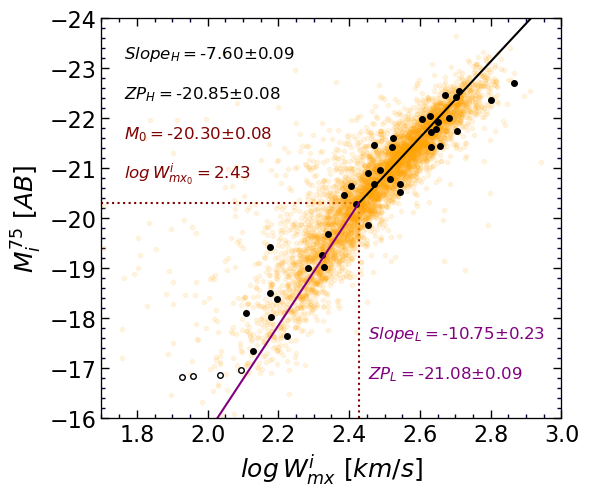

In [10]:
def bilinear(x, m1, b1, m2, eps):
    x0 = -20+eps 
    b2 = b1 - x0*(m2-m1)
    y1 = m1 * x + b1
    y2 = m2 * x + b2
    y = np.asarray([y1[i] if x[i]<=x0 else y2[i] for i in range(len(x))])
    return y



dff = df[(df.Vmod>4000) & (df[band3]>0) & (df.Sqlt>2)]
mag_f = dff[Band].values
logWimx_f = dff.logWimx.values
logWimx_e_f = dff['logWimx_e'].values
fit, cov = curve_fit(bilinear, mag_f, logWimx_f-2.5, sigma=np.sqrt(logWimx_e_f**2+0.01**2))
M0 = -20+fit[3] 

def bilinear2(x, m1, b1, m2, b2):
    y1 = m1 * x + b1
    y2 = m2 * x + b2
    y = np.asarray([y1[i] if x[i]<=M0 else y2[i] for i in range(len(x))])
    return y

fit, cov = curve_fit(bilinear2, mag_f, logWimx_f-2.5, sigma=np.sqrt(logWimx_e_f**2+0.01**2))
m1 = fit[0]
b1 = fit[1]
m2 = fit[2]
b2 = fit[3]

def bilinear_zp(x, zp):
    
    return bilinear2(x+zp, m1, b1, m2, b2)



dM, cov_dm = curve_fit(bilinear_zp, calib.I.values, calib.logWimx.values-2.5, 
                     sigma=np.sqrt(calib.logWimx_e.values**2+0.01**2))



fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1




dff = df[(df.Vmod>4000) & (df[band3]>0) & (df.Sqlt>2)]
ax.plot(dff.logWimx.values, dff[Band].values-dM[0], '.', alpha=0.1, color='orange')

###############################################################################################
###############################################################################################
# X = dff.logWimx.values
# Y = dff[Band].values-dM[0]


# for i in np.arange(2.,2.9,0.05):
#     xp = []
#     yp = []
#     for ii in range(len(X)):
#         xi = X[ii]
#         if xi>=i and xi<i+0.05:
#             xp.append(xi)
#             yp.append(Y[ii])
#     if len(xp)>0:
#         ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
#                     color='r', ms=6)  
###############################################################################################
###############################################################################################

ax.plot(calib.logWimx.values, calib.I.values, 'ko', alpha=1, ms=4)
ax.plot(calib_.lgWmxi.values, calib_.I.values, 'ko', alpha=1, ms=4, mfc='white')

v = np.linspace(-24,M0-dM[0],100)
u = m1*(v+dM[0]) + b1 + 2.5
ax.plot(u, v, '-', color='black')
v = np.linspace(M0-dM[0],-14,100)
u = m2*(v+dM[0]) + b2 + 2.5
ax.plot(u, v, '-', color='purple')

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$M^{75}_{i} \/\/ [AB]$', fontsize=18)
set_axes(ax, (1.7,3), (-16,-24))

#########################################################################################
m1 = fit[0] ; dm1 = cov[0][0]
b1 = fit[1] ; db1 = cov[1][1]
m2 = fit[2] ; dm2 = cov[2][2]
b2 = fit[3] ; db2 = cov[3][3]

m1e = np.sqrt(dm1)
b1e = np.sqrt(db1)
mbe = cov[1,0]    
m10 = 1./m1
b10 = -b1/m1
dm10 = np.abs(m1e/m1**2)
db10 = np.sqrt((b10**2 )*(b1e**2/b1**2+m1e**2/m1**2-2*mbe/m1/b1))


m2e = np.sqrt(dm2)
b2e = np.sqrt(db2)
mbe = cov[2,3]    
m20 = 1./m2
b20 = -b2/m2
dm20 = np.abs(m2e/m2**2)
db20 = np.sqrt((b20**2 )*(b2e**2/b2**2+m2e**2/m2**2-2*mbe/m2/b2))



print(m10, b10, dm10, db10)
print(m20, b20, dm20, db20)
print(M0-dM[0], cov_dm[0][0])
# (-7.602701011543559, -20.987931668870026, 0.08533213678309576, 0.010051521822623736)
# (-10.74639929921481, -21.21504791045947, 0.2253335371429567, 0.04003184638690257)
# -20.316893533266967
logW0 = 0.5*(m1*(M0)+b1+2.5+m2*(M0)+b2+2.5)

b10_f = b10-dM[0]
b20_f = b20-dM[0]

db10_f = np.sqrt(cov_dm[0][0]+db10**2)
db20_f = np.sqrt(cov_dm[0][0]+db20**2)
print("zp1", b10_f, db10_f)
print("zp2", b20_f, db20_f)

Mt1 = m10*(logW0-2.5) + b10_f
Mt2 = m20*(logW0-2.5) + b20_f

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.90*Ylm[1]
ax.text(x0,y0, r"$Slope_H = $"+"%.2f" % m10+'$\pm$'+"%.2f" % dm10, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.80*Ylm[1]
ax.text(x0,y0, r"$ZP_H = $"+"%.2f" % b10_f+'$\pm$'+"%.2f" % db10_f, fontsize=12, color='k')
y0 = 0.3*Ylm[0]+0.70*Ylm[1]
ax.text(x0,y0, r"$M_0 = $"+"%.2f" % (0.5*(Mt1+Mt2))+'$\pm$'+"%.2f" % np.sqrt(cov_dm[0][0]), fontsize=12, color='maroon')
y0 = 0.4*Ylm[0]+0.60*Ylm[1]
ax.text(x0,y0, r'$log \/ W_{mx_0}^i = $'+"%.2f" % (logW0), fontsize=12, color='maroon')



Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.42*Xlm[0]+0.58*Xlm[1]
y0 = 0.80*Ylm[0]+0.2*Ylm[1]
ax.text(x0,y0, r"$Slope_L = $"+"%.2f" % m20+'$\pm$'+"%.2f" % dm20, fontsize=12, color='purple')
y0 = 0.90*Ylm[0]+0.10*Ylm[1]
ax.text(x0,y0, r"$ZP_L = $"+"%.2f" % b20_f+'$\pm$'+"%.2f" % db20_f, fontsize=12, color='purple')

ax.vlines(x=logW0, ymin=-16, ymax=Mt1, color='maroon', linestyle='dotted')
ax.hlines(y=Mt1, xmin=1.7, xmax=logW0, color='maroon', linestyle='dotted')

# ax.plot(gp_yp_test, x_test-dM[0], 'r-', alpha=1)
# ax.fill_betweenx(x_test-dM[0], gp_yp_test-3*np.sqrt(gp_yp_test_std), gp_yp_test+3*np.sqrt(gp_yp_test_std),
#                 color='red', alpha=0.2)

Mt1, Mt2, dM[0]

In [11]:
from sklearn.model_selection import train_test_split
import george
from george import kernels

def GPR(X, y, lnlikelihood=True):
  '''
  The output of this function is another function, either the lnlikelihood, or 
  the gp (the gaussian process regressor that is dfined by giving theta)
  '''
  n = X.shape[1]
    
  def step(theta):

        L = np.exp(theta[:n])
        sigma = np.exp(theta[n])   
        yerr = np.exp(theta[n+1])
        
        kernel = sigma * kernels.ExpSquaredKernel(np.ones(n), ndim=n)

        gp = george.GP(kernel)

        if lnlikelihood:
            
          gp = george.GP(kernel)
          gp.compute(X / np.vstack([L]*X.shape[0]), yerr)
       
          return -gp.lnlikelihood(y)
        else:
          X0 = X / np.vstack([L]*X.shape[0])
          gp.compute(X0, yerr)
          return gp
      
  return step

In [76]:
dff = df[(df.Vmod>4000) & (df[band3]>0) & (df.Sqlt>2)]

Y = dff.logWimx.values
Ye = dff.logWimx_e.values*0+0.01
X = dff[Band].values

# X = X[indx_del]
# Y = Y[indx_del]
# Ye = Ye[indx_del]

XS2 = X.reshape(len(X), 1)
ys2 = Y
ys2e = Ye

len(Y)

5398

In [77]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
kf.get_n_splits(XS2)

def Xi2_swarm(x):
  
  nParticle = x.shape[0]
  out = np.zeros(nParticle)

  for train_index, cross_index in kf.split(XS2):
    
      X_train, X_cross = XS2[train_index], XS2[cross_index]
      y_train, y_cross = ys2[train_index], ys2[cross_index]
      ye_train, ye_cross = ys2e[train_index], ys2e[cross_index]

      n = X_cross.shape[1]
      m = X_cross.shape[0]

      for n_iter in range(nParticle):
          
          theta = x[n_iter,:]

          L = np.exp(theta[:n])

          gp = GPR(X_train, y_train, lnlikelihood=False)(theta)
          gp_yp_cross, gp_yp_cross_std = gp.predict(y_train, X_cross/np.vstack([L]*m), return_var=True)

          out[n_iter] += np.sum((y_cross - gp_yp_cross)**2/ye_cross**2)

  return out

In [40]:
# Import modules
import numpy as np
from pyswarms.single.global_best import GlobalBestPSO
# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
%%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = GlobalBestPSO(n_particles=10, dimensions=3, options=options)

# Perform optimization
cost, pos = optimizer.optimize(Xi2_swarm, iters=10)

2020-12-23 23:34:13,436 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|10/10, best_cost=4.23e+5
2020-12-23 23:46:25,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 422798.8064871025, best pos: [2.57860022 3.42156733 0.33875042]


CPU times: user 38min 42s, sys: 7min, total: 45min 42s
Wall time: 12min 11s


In [78]:
pos
pos = np.asarray([2.57860022, 3.42156733, 0.33875042])

In [79]:
truths = pos
gp = GPR(XS2, ys2, lnlikelihood=False)(truths)

x_test = np.linspace(-25, 0, 10000)
XS_test = x_test.reshape(10000,1)

n = XS2.shape[1]
m_test = XS_test.shape[0]
m = XS2.shape[0]
L = np.exp(truths[:n])


gp_yp, gp_yp_std = gp.predict(ys2, XS2/np.vstack([L]*m), return_var=True)
gp_yp_test, gp_yp_test_std = gp.predict(ys2, XS_test/np.vstack([L]*m_test), return_var=True)

(<AxesSubplot:label='25717842-c342-4a94-904a-543eae3650f8'>,
 <AxesSubplot:label='1de11f78-c2f5-4b9e-9a53-0106d694ddcb'>)

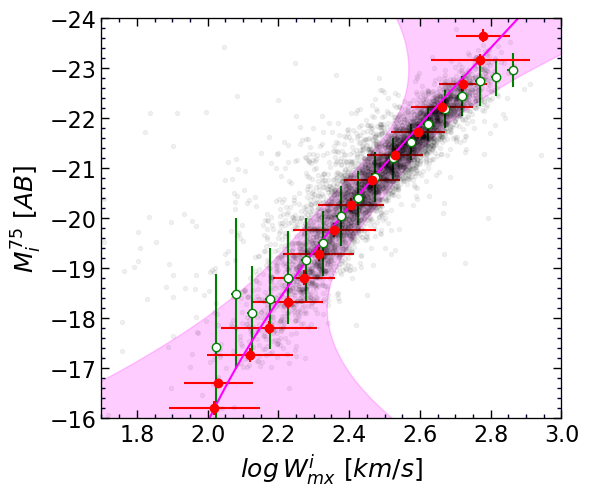

In [80]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

# dff = df[(df.Vmod>4000) & (df[band3]>0) & (df.Sqlt>2)]

Y = dff.logWimx.values
Ye = dff.logWimx_e.values
X = dff[Band].values


# ax.plot(Y[indx_del], X[indx_del], 'k.', alpha=0.05)
ax.plot(Y, X, 'k.', alpha=0.05)





# ax.plot(gp_yp_test_, x_test, 'g-', alpha=1)
# ax.fill_betweenx(x_test, gp_yp_test_-3*np.sqrt(gp_yp_test_std_), gp_yp_test_+3*np.sqrt(gp_yp_test_std_),
#                 color='green', alpha=0.2)

ax.set_ylim(-16, -24)


###############################################################################################
for i in np.arange(2.,2.9,0.05):
    xp = []
    yp = []
    for ii in range(len(Y)):
        xi = Y[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(X[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='g', ms=6, mfc='white')   
###############################################################################################

for i in np.arange(-24,-16,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(yp), np.median(xp), yerr=np.std(xp), xerr=np.std(yp), fmt='o', 
                    color='r', ms=6)  
###############################################################################################

ax.plot(gp_yp_test, x_test, 'r', alpha=1, color='magenta')

ax.fill_betweenx(x_test, gp_yp_test-3*np.sqrt(gp_yp_test_std), gp_yp_test+3*np.sqrt(gp_yp_test_std),
                color='magenta', alpha=0.2)


ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$M^{75}_{i} \/\/ [AB]$', fontsize=18)
set_axes(ax, (1.7,3), (-16,-24))

<AxesSubplot:>

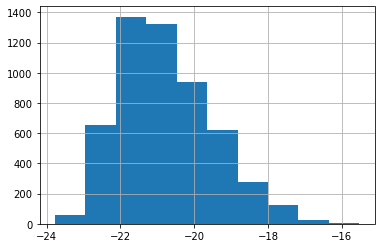

In [81]:
dff[Band].hist()

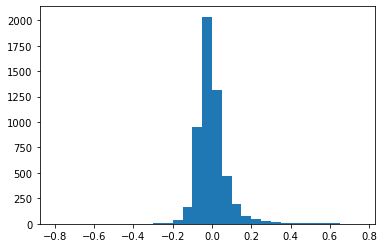

In [82]:
delta = gp_yp-ys2

bins = np.arange(-0.8,0.8,0.05)

plt.hist(delta, bins=bins)

indx_del, = np.where(np.abs(delta)<0.3)

In [83]:
np.mean(delta)

-5.212751997072227e-05

In [84]:
from scipy.interpolate import interp1d


truths = pos
gp = GPR(XS2, ys2, lnlikelihood=False)(truths)



n = XS2.shape[1]
m = XS2.shape[0]
L = np.exp(truths[:n])




def GP_zp(I, zp):
    x_test = I+zp
    XS_test = x_test.reshape(len(x_test),1)
    m_test = XS_test.shape[0]
    gp_yp_test, gp_yp_test_std = gp.predict(ys2, XS_test/np.vstack([L]*m_test), return_var=True)
    
    return gp_yp_test
    
    

dM_, cov_dm = curve_fit(GP_zp, calib.I.values, calib.logWimx.values, 
                     sigma=np.sqrt(calib.logWimx_e.values**2+0.01**2))

In [85]:
dM_

array([-0.26507115])

In [86]:


# dff = df[(df.Vmod>4000) & (df[band3]>0) & (df.Sqlt>2)]

Y = dff.logWimx.values
Ye = dff.logWimx_e.values
X = dff[Band].values

ax.plot(Y, X-dM_[0], 'k.', alpha=0.05)
ax.plot(gp_yp_test, x_test-dM_[0], 'r', alpha=1, color='magenta')

# ax.fill_betweenx(x_test, gp_yp_test-3*np.sqrt(gp_yp_test_std), gp_yp_test+3*np.sqrt(gp_yp_test_std),
#                 color='magenta', alpha=0.2)

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$M^{75}_{i} \/\/ [AB]$', fontsize=18)
set_axes(ax, (1.7,3), (-16,-24))



ax.plot(calib.logWimx.values, calib.I.values, 'ko', alpha=1, ms=4)
ax.plot(calib_.lgWmxi.values, calib_.I.values, 'ko', alpha=1, ms=4, mfc='white')


v = np.linspace(-24,M0-dM[0],100)
u = m1*(v+dM[0]) + b1 + 2.5
ax.plot(u, v, '-', color='red')
v = np.linspace(M0-dM[0],-14,100)
u = m2*(v+dM[0]) + b2 + 2.5
ax.plot(u, v, '-', color='red')

In [87]:
dM[0], dM_[0]

(-0.13720764252371348, -0.26507115277917026)

In [88]:
myDict = {"logW": gp_yp_test, "Mag": x_test}#-dM_[0]-0.10}
myDF = pd.DataFrame.from_dict(myDict)

myDF.to_csv("GP_TF.csv")

In [89]:
myDF = pd.read_csv("GP_TF.csv")
myDF = myDF[myDF.Mag<-14]
logW = dff.logWimx.values

from scipy.interpolate import interp1d

minW = myDF.logW.values.min()


f1 = interp1d(myDF.logW.values, myDF.Mag.values, kind='linear')



dff = dff[dff.logWimx>minW]
dff['I'] = f1(dff.logWimx)

In [90]:
tf = dff
tf['delta'] = tf.M_i-tf.I
tf.head()

,Vh,Vls,V3k,Vmod,f_cosmology,logWimx,logWimx_e,inc,Sqlt,Wqlt,...,DM_src,logD,DM,M_r,M_i,M_z,M_1,M_2,I,delta
pgc,,,,,,,,,,,,,,,,,,,,,
4.0,4458,4706,4109,4154,1.011,2.189,0.014,85,5,4,...,1,1.743405,33.717026,-18.387026,-18.597026,-18.647026,-17.647026,-17.277026,-18.240374,-0.356652
16.0,5667,5809,5312,5387,1.014,2.515,0.025,65,5,5,...,1,1.856286,34.281429,-20.421429,-20.701429,-20.881429,-20.291429,-19.581429,-21.188981,0.487552
55.0,4779,5052,4454,4507,1.012,2.260,0.025,80,5,4,...,1,1.778826,33.894131,-18.574131,-18.674131,-18.724131,-17.694131,-17.264131,-18.954955,0.280824
68.0,7664,7740,7338,7480,1.019,2.390,0.043,57,5,5,...,1,1.998840,34.994202,-20.384202,-20.474202,-20.654202,-19.964202,-19.454202,-20.142856,-0.331346
70.0,6800,7040,6447,6557,1.017,2.636,0.005,90,5,5,...,1,1.941644,34.708220,-21.248220,-21.468220,-21.688220,-21.168220,-20.598220,-22.147666,0.679447


0.10063965407192477


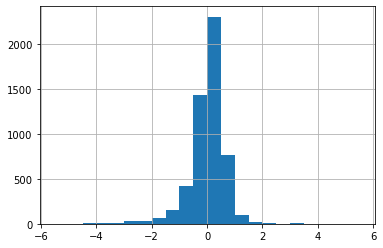

In [91]:
bins = np.arange(-5.5, 6, 0.5)

tf.delta.hist(bins=bins)

print(np.median(tf.delta.values))

4591.0 0.14550672442980073
5417.0 0.13852743810072177
6615.0 0.09800739963626626
7414.5 0.09326033150396107
8484.0 0.09175049129960655
9460.5 0.06663119230351988
10528.0 0.13141300118848065
11486.5 0.036332133611795214
12427.0 0.06344297162858403
13452.5 0.07264782674250192
14411.5 0.008602273796062931
15553.0 0.06380112039215291
16577.0 -0.09173517344102144
17320.5 0.007634483505723821
18238.0 -0.0873771846664706
19274.0 0.0025587047786359562
1.6483636426156756


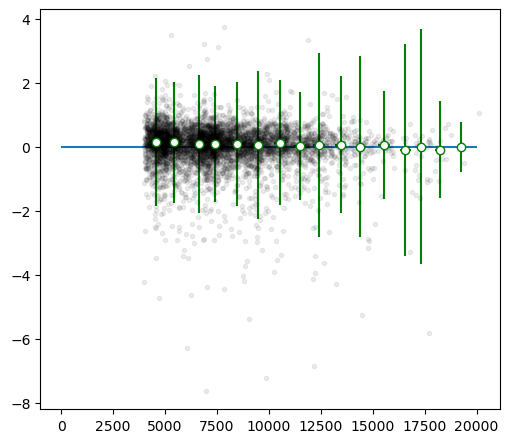

In [92]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1



X = tf.Vmod.values
Y = tf.delta.values

plt.plot(X, Y, 'k.', alpha=0.07)
listjzg=[]
for i in np.arange(4000,20000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=3*np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='g', ms=6, mfc='white')   
        
        print(np.median(xp), np.median(yp))
        listjzg.append(2.5*np.std(yp))
        
listjzg = np.asarray(listjzg)

print(np.median(listjzg))

ax.hlines(0,0,20000)

-23.65133202700231 -0.41086230804789103
-23.15661210520386 0.0025587047786359562
-22.682090948595395 0.12195928155691149
-22.216733349458856 0.12065627083247321
-21.727341904915697 0.1062996565434986
-21.25363803858454 0.04767716747438833
-20.754072817359287 0.03587473178523837
-20.265401729875414 0.03451741740781955
-19.76068183338613 0.1255413137410386
-19.283937963290352 0.20594365324585873
-18.807348716267008 0.3005373399192628
-18.315141584831423 0.3847441778354437
-17.810386316865905 0.2919791562461498
-17.25028715989299 0.33387832183851174
-16.69270238052506 -0.4477363418240312
-16.21317200612426 0.20579086539805047
1.72939836034757


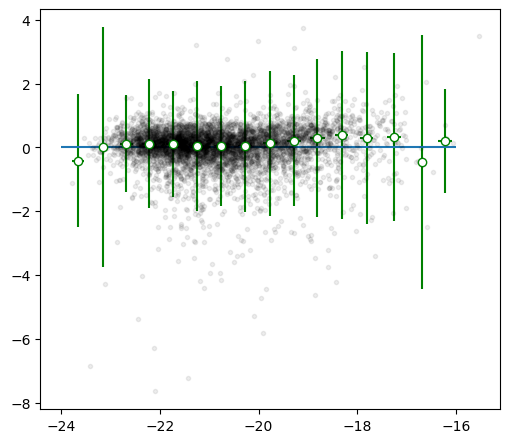

In [93]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1



X = tf.M_i.values
Y = tf.delta.values

plt.plot(X, Y, 'k.', alpha=0.07)
listjzg=[]
for i in np.arange(-24, -16, 0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=3*np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='g', ms=6, mfc='white')   
        
        print(np.median(xp), np.median(yp))
        listjzg.append(2.5*np.std(yp))
        
listjzg = np.asarray(listjzg)

print(np.median(listjzg))

ax.hlines(0, -24, -16)

In [94]:
len(dff)

5368